In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

# Question 1

In [2]:
df = pd.read_csv("Q1.csv", index_col=0)
df = df.sort_values(by='x')
df.head(5)

,x,y
101,0.016776,-11.322324
106,0.073914,-12.985123
141,0.180451,-6.240498
289,0.188039,-13.613464
127,0.241295,-10.354687


In [3]:
x, y = df['x'].values, df['y'].values


In [4]:
def spline(X, y, X_function, return_coeffs=False):
    X = X_function(X)
    coefficients = scipy.linalg.inv(X.T @ X) @ (X.T @ y)
    spline = lambda z: X_function(z) @ coefficients

    ans = [spline]
    if return_coeffs:
        ans.append(coefficients)
    return tuple(ans)

1.  Find the best fitting linear spline model to estimate $f$, with two knots at $x = 3$ and $x = 7$.

In [5]:
knots = [3., 7.]
n = 4 # (1, x, (x-knots_0)+, (x-knots_1)+)

X_function = lambda z: np.stack((np.ones((len(z))), z, np.maximum(z-knots[0], 0), np.maximum(z-knots[1], 0)), axis=1)

spl, coeffs = spline(x, y, X_function, return_coeffs=True)
coeffs

array([-10.92599911,   6.63934379,  -9.46158565,   3.80098199])

Thus, the spline regression function is:
$
    y = -10.9 + 6.6x - 9.5 (x-3)_+ + 3.8 (x-5)_+
$

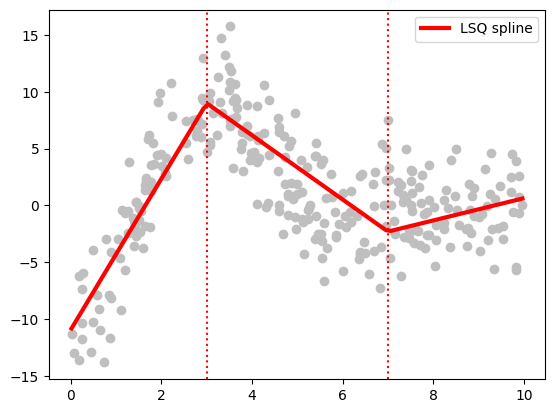

In [6]:
xs = np.linspace(x[0], x[-1], 100)
plt.plot(x, y, 'o', color='0.75')
plt.plot(xs, spl(xs), 'r-', lw=3, label='LSQ spline')
plt.legend(loc='best')

for knot in knots:
    plt.axvline(x=knot, color='red', linestyle='dotted')
plt.show()

2. Find the best fitting cubic spline model to estimate $f$, with one knot at $x = 5$.

In [7]:
knots = [5.]
n = 5 # (1, x, x^2, x^3, (x-knot)^3+)

X_function = lambda z: np.stack((np.ones((len(z))), z, z**2, z**3, np.minimum(z-knots[0], 0)**3), axis=1)

spl, coeffs = spline(x, y, X_function, return_coeffs=True)
coeffs

array([ 2.85910164e+01, -8.07192283e+00,  6.13034042e-01, -8.50325153e-03,
        3.72595655e-01])

Thus, the spline regression function is:
$
    y = 28.6 - 8.1x + 0.61 x^2 - 0.0085 x^3 + 0.37 {(x-5)^3}_+
$

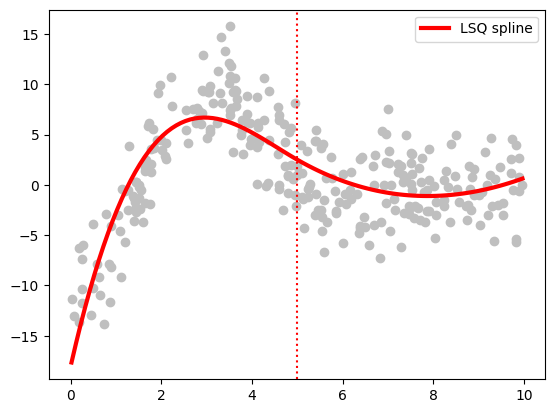

In [8]:
xs = np.linspace(x[0], x[-1], 100)
plt.plot(x, y, 'o', color='0.75')
plt.plot(xs, spl(xs), 'r-', lw=3, label='LSQ spline')
plt.legend(loc='best')

for knot in knots:
    plt.axvline(x=knot, color='red', linestyle='dotted')
plt.show()

3. Fit three smoothing splines to estimate $f$ with smoothing parameter $\lambda = 10^{−7}$, $\lambda = 10^{−4}$ and $\lambda = 10^{−1}$, respectively.

In [10]:
lambdas = [1e-7, 1e-4, 1e-1]
colors = ['c', 'm', 'k']
styles = ['dotted', 'dashed', 'solid']

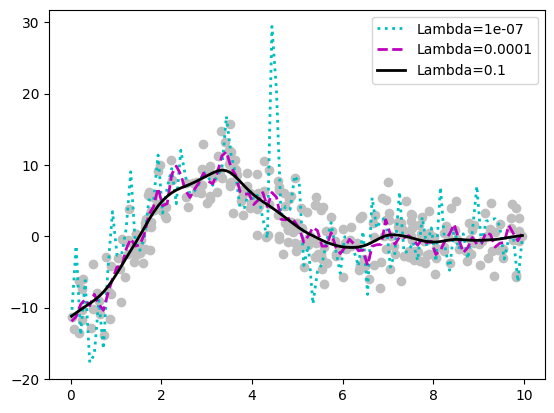

In [11]:
xs = np.linspace(x[0], x[-1], 100)
plt.plot(x, y, 'o', color='0.75')
for lam, color, style in zip(lambdas, colors, styles):
    spl = scipy.interpolate.make_smoothing_spline(x, y, lam=lam)
    plt.plot(xs, spl(xs), color, linestyle=style,lw=2, label=f'Lambda={lam}')

plt.legend(loc='best')

plt.show()



### APPARENTLY THE SCIPY SMOOTHING SPLINE PRODUCES DIFFERENT RESULTS THAN THE R PACKAGE. HOWEVER, INSPECTING THE DOCUMENTATION OF THE PACKAGE, THE FORMULA OF THE SMOOTHING SPLINE IS VERY SIMILAR TO THE ONE IN LECTURE NOTES.

4. We see that the scatter plot of the data is quite flat when $x > 5$. Fit a special cubic spline $f$ (with one knot at $x = 5$) to estimate $f$ such that
- $f$ is linear for $x > 5$;
- $f$ is cubic for $x \leq 5$;
- $f$ has continuous second derivative at the knot $x = 5$.

In [13]:
knots = [5.]
n = 3 # (1, x, (x-knots)-^3)

X_function = lambda z: np.stack((np.ones((len(z))), z, np.minimum(z-knots, 0)**3), axis=1)

spl, coeffs = spline(x, y, X_function, return_coeffs=True)
coeffs

array([11.46995132, -1.51641611,  0.20593344])

To accomodate for a continuous second derivative, the second derivative at $x=5$ has to be equal to 0. Thus we drop the quadratic parameter. Thus, the spline regression function is:
$
    y = 11.5 - 1.5x + 0.2 {(x-5)^3}_+
$

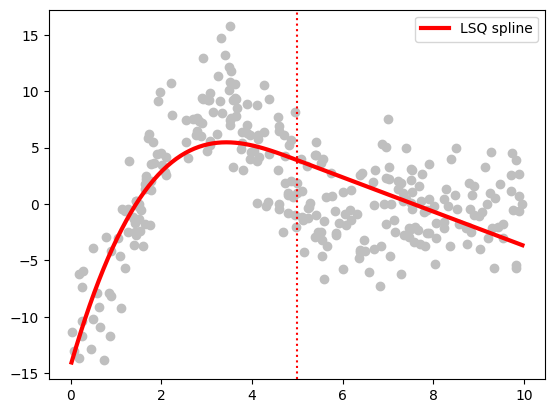

In [15]:
xs = np.linspace(x[0], x[-1], 100)
plt.plot(x, y, 'o', color='0.75')
plt.plot(xs, spl(xs), 'r-', lw=3, label='LSQ spline')
plt.legend(loc='best')

for knot in knots:
    plt.axvline(x=knot, color='red', linestyle='dotted')
plt.show()

# Question 2

In [52]:
df = pd.read_csv("Q2.csv", index_col=0)
df.head(5)

,x1,x2,y
1,1.041478,2.294833,1
2,0.930416,-0.074211,1
3,-0.417394,-0.713259,0
4,1.448601,0.043548,0
5,0.867857,0.784432,1


In [53]:
z, y = np.split(df, [2], axis=1)
H = np.array([[.5, 0], [0, 0.5]])


1. Derive and programme the estimator for $p(x_1,x_2)$ based on kernel density classification. Plot the level plot for the estimated $p(x_1,x_2)$.

In [63]:
def kernel(u, bandwidth): 
    return np.exp(-0.5 * (u / bandwidth)**2) / (np.sqrt(2 * np.pi) * bandwidth)

def multivariate_kde(data, bandwidth, kernel):
    if isinstance(data, pd.DataFrame):
        data = data.drop('y', axis=1)
        data = data.values
    
    def density(datapoints):
        if isinstance(datapoints, pd.DataFrame):
                datapoints = datapoints.values

        U = (datapoints[:, None, :] - data) @ np.linalg.inv(bandwidth)
        kernel_product = np.prod(kernel(U, 1), axis=2)
        weights = kernel_product / np.linalg.det(bandwidth)
        f = np.mean(weights, axis=1) 
        return pd.Series(f)
    return density

def kdc(data: pd.DataFrame, bandwidth, kernel):
    gb = data.groupby('y', group_keys=False)
    pi = (gb.size()/len(data)).values
    
    def inner(datapoints):
        h = gb.apply(lambda x: multivariate_kde(x, bandwidth, kernel)(datapoints)).T.values
        h *= pi[None, :]
        h /= h.sum(axis=1)[:,None]
        return h

    return inner

In [64]:
max_vals = df.max(axis=0, numeric_only=True)
min_vals = df.min(axis=0, numeric_only=True)
new_x, new_y = np.meshgrid(
    np.linspace(min_vals[0], max_vals[0], 100),
    np.linspace(min_vals[1], max_vals[1], 100)
)

datapoints = np.vstack([new_x.ravel(), new_y.ravel()]).T

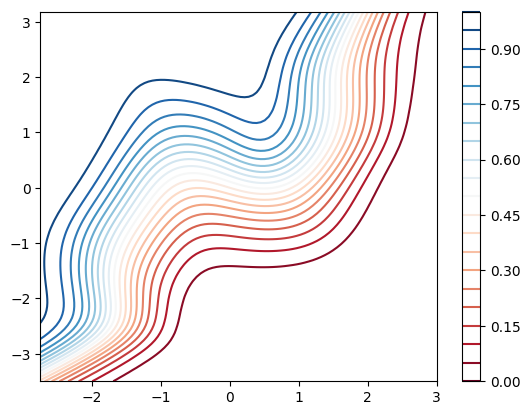

In [65]:
m = kdc(df, H, kernel)

plt.contour(new_x, new_y, np.reshape(m(datapoints)[:,1], (100, 100)), 20, cmap='RdBu')
plt.colorbar()
plt.show()

2. Plot the prediction $y_i$'s for all the data points $(x_{i1},x_{i2})$’s

In [66]:
def find_metrics(y_true, y_pred):
    true_positive = (y_true == 1) & (y_pred == 1)
    true_negative = (y_true == 0) & (y_pred == 0)
    false_positive = (y_true == 0) & (y_pred == 1)
    false_negative = (y_true == 1) & (y_pred == 0)
    return true_positive, true_negative, false_positive, false_negative

def pred(datapoints):
    return np.argmax(m(datapoints), axis=1)

In [67]:
y_pred = pred(df.drop('y', axis=1))
tp, tn, fp, fn = find_metrics(df['y'], y_pred)

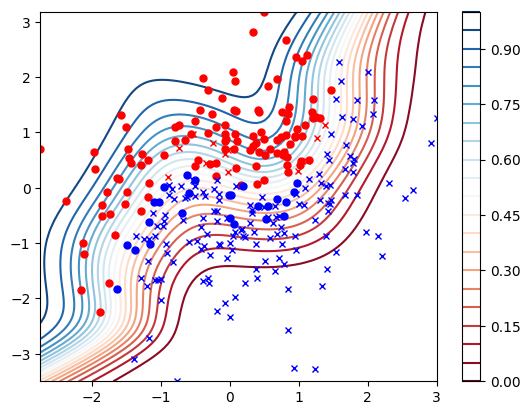

In [68]:
plt.contour(new_x, new_y, np.reshape(m(datapoints)[:,1], (100, 100)), 20, cmap='RdBu')
plt.colorbar()

plt.plot(df[tp]['x1'], df[tp]['x2'], 'or', ms=5)
plt.plot(df[tn]['x1'], df[tn]['x2'], 'xb', ms=5)

plt.plot(df[fp]['x1'], df[fp]['x2'], 'xr', ms=5)
plt.plot(df[fn]['x1'], df[fn]['x2'], 'ob', ms=5)
plt.show()

3. Is this estimator equivalent to a Naive Bayes estimator?

Naive Bayes assumes that:
$ 
\mathcal{f}(\mathbf{X}) = \prod^d_{k=1} \mathcal{f}_i(\mathbf{X}_k).
$

The multivariate kernel density estimator uses a product kernel:

$ 
\mathcal{f}_H(\mathbf{X}) = \frac{1}{n} \sum^n_{i=1} \frac{1}{\det{\mathbf{H}}} \mathcal{K} \{H^{-1} (\mathbf{x}-\mathbf{X_i})\},
$

where $\mathcal{K}\{ \mathbf{X} \} = \prod^d_{j=1}\mathrm{K}\{\mathbf{X_i}\}$. However, there is no manipulation possible to swap the product and summation signs. Therefore, the kde cannot be written in a similar way like that of a Naive Bayes estimator. Thus, it is not fulfill the NB assumption. Furthermore, a non-diagonal bandwidth matrix would further complicate this.

# Question 3

In [24]:
import sys
!{sys.executable} -m pip install rpy2
%load_ext rpy2.ipython

c:\Users\gonem\CodeProjects\advanced-statistics\venv\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [70]:
df = pd.read_csv("Q3.csv", index_col=0)
df.head(5)

,x1,x2,y
1,-1.400108,-0.203306,1.759950
2,-1.258428,0.599813,6.948210
3,0.923265,0.465499,-0.657786
4,-0.541623,-0.370584,1.420613
5,1.718462,1.236809,-1.482097


1. Fit a single-index model to estimate $f$: 
$ 
f(x) = g(β_1x_1 + β_2x_2). 
$
Plot the fitted nonparametric function $g$ and give the estimated values $β_1, β_2$.

R[write to console]: Warning:
R[write to console]:  package 'np' is in use and will not be installed



Multistart 1 of 2.Multistart 2 of 2.                  
Single Index Model
Regression Data: 300 training points, in 2 variable(s)

      x1        x2
Beta:  1 -1.836592
Bandwidth: 0.1356948
Kernel Regression Estimator: Local-Constant

Residual standard error: 0.95459
R-squared: 0.9729999

Continuous Kernel Type: Second-Order Gaussian
No. Continuous Explanatory Vars.: 1



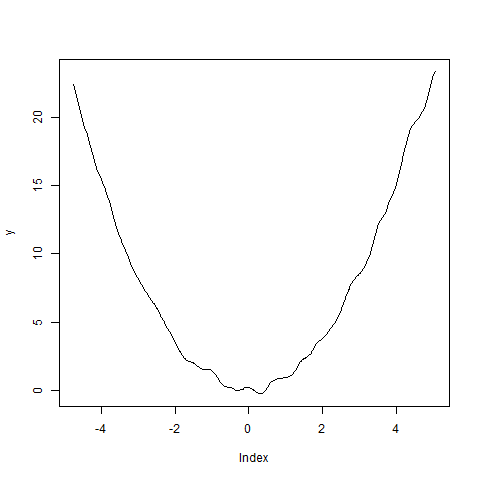

In [71]:
%%R -i df

install.packages("np", repos='http://cran.us.r-project.org', quiet=TRUE)
library(np)

bw <- npindexbw(formula=y~x1+x2, data=df, method='ichimura')
model <- npindex(bws=bw)
summary(model)
npplot(bws=bw)

Thus the parameters are: $β_1=1, β_2=-1.8$

2. Fit an additive model to estimate $f$:
$
f(x) = c + g_1(x_1) + g_2(x_2).
$
Give the value for $c$ and plot the fitted nonparametric functions $g_1, g_2$.

R[write to console]: Warning:
R[write to console]:  package 'mgcv' is in use and will not be installed




Family: gaussian 
Link function: identity 

Formula:
y ~ 1 + s(x1) + s(x2)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    5.361      0.272   19.71   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
        edf Ref.df      F p-value    
s(x1) 2.301  2.876  1.321   0.208    
s(x2) 4.540  5.560 27.008  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.343   Deviance explained = 35.8%
-REML = 895.67  Scale est. = 22.189    n = 300


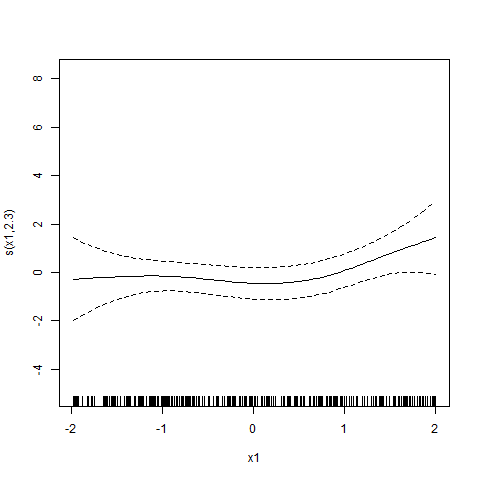

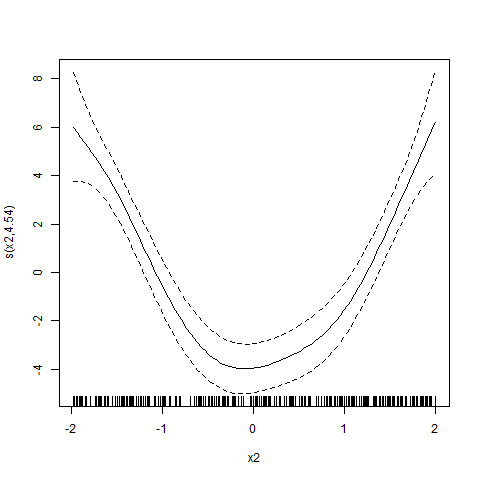

In [72]:
%%R -i df

install.packages("mgcv", repos='http://cran.us.r-project.org', quiet=TRUE)
library(mgcv)

m <- gam(y~1 + s(x1)+s(x2), data=df, method='REML')
plot(m)
summary(m)

In [28]:
df['y'].mean()

5.3605570793211275

Thus the parameter is: $c=5.4$

3. Inspect the fitted results from the previous two parts. Which do you think
is a better model for the data, the single index model or the additive model? Give
your reason.

A quick view at the $R^2$ values indicates that the single index model is highly preferable over the additive model. Furthermore, the $g_1$ plot indicates that this function might be zero. As the zero fits at every points between the confidence interval.

4. Is the following statement true? Give your reason.
The single-index model and the addtive model characterise two different structures in
the data. Therefore for any dataset, at least one of the them would be a bad fit.

False. 

As in the statement, I do agree that both models characterize different structures in the data. A model would produce a bad fit once an assumption does not hold. However, some data structures can be captured by both models. For example, a simple linear Data Generating Function: $\beta_1x_1+\beta_2x_2$ can be captured well by both the single-index and additive model. Therefore, the statement is false. (However, it could be that both models produce a bad fit with a highly complex DGF.)

# Question 4

In [29]:
df = pd.read_csv("Q4.csv", index_col=0)
x, y = np.split(df, [1], axis=1)
df.head(5)

,x,y
1,1.510086,6.521088
2,1.074133,4.108957
3,-0.884147,-1.776799
4,0.116655,1.813323
5,1.851628,7.329740


1. Programme the estimator $m$ for $k = 20$ and $h = 1$. Plot the estimated $m$. Include also the observed data points in your plot (similar to the figures in Lecture
3).

In [30]:
def mask_k(x, k, top=True, inplace=False):
    if not top:
        x = -x
    m, n = x.shape
    # get (unsorted) indices of top-k values
    topk_indices = np.argpartition(x, -k, axis=1)[:, -k:]
    # get k-th value
    rows, _ = np.indices((m, k))
    kth_vals = x[rows, topk_indices].min(axis=1)
    # get boolean mask of values smaller than k-th
    best = x >= kth_vals[:, None]
    return best

In [31]:
def univariate_kernelh_knn(covariates, y, bandwidth=1, neighbors=5):
    if isinstance(covariates, pd.DataFrame):
        covariates = covariates.values

    if isinstance(y, pd.DataFrame):
        y = y.values

    def inner(datapoints):
        distance = np.linalg.norm(datapoints[:, None, :]-covariates, axis=2)

        closest_points = mask_k(distance, neighbors, top=False)
        best_k_distances = np.where(~closest_points, np.inf, distance)
        weights = kernel(best_k_distances, bandwidth)

        m = weights @ y.squeeze()
        m /= weights.sum(axis=1)
        return m
    return inner

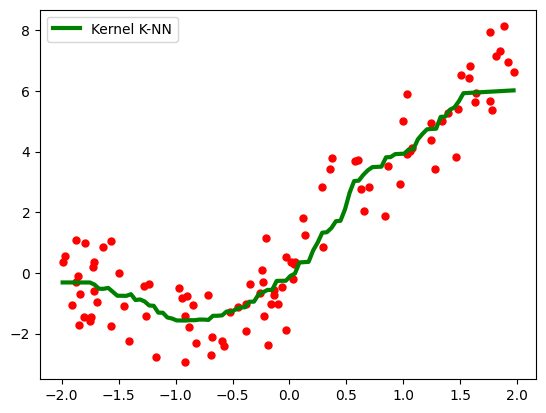

In [32]:
import matplotlib.pyplot as plt
plt.plot(x, y, 'ro', ms=5)

datapoints = np.linspace(x.min(), x.max(), 100)
plt.plot(datapoints, univariate_kernelh_knn(x, y, bandwidth=1, neighbors=20)(datapoints), 'g-', lw=3, label='Kernel K-NN')
plt.legend(loc='best')
plt.show()

2. Select the optimal $h$ and $k$ using the leave-one-out cross validation. You can search within the grid of $k = \{1,2,...,50\}$ and $h = \{0.01,0.02 ...,2\}$.

In [33]:
def scorer(y_true, y_pred, order=2):
    return np.mean(np.abs(y_true - y_pred) ** order)


def loocv_score(x, y, bandwidth, neighbors):
    n = len(x)
    
    if isinstance(x, pd.DataFrame):
        x = x.values

    if isinstance(y, pd.DataFrame):
        y = y.values
    
    scores = []
    for i in range(n):
        x_train = np.delete(x, i, axis=0)
        y_train = np.delete(y, i)
        y_true = np.array(y[i, np.newaxis])
        y_pred = univariate_kernelh_knn(x_train, y_train, bandwidth, neighbors)(np.array(x[i, np.newaxis]))
        scores.append(scorer(y_true, y_pred))
    return np.mean(scores)


def optim(x, y, bandwidths, neighbors):
    hyperparameter_scores = []
    for bandwidth in bandwidths:
        for neighbor in neighbors:
            score = loocv_score(x, y, bandwidth, neighbor)
            hyperparameter_scores.append([bandwidth, neighbor, score])
    return hyperparameter_scores

In [34]:
scores = optim(x, y, bandwidths=np.arange(0.01, 2.01, 0.01), neighbors=np.arange(1, 51))

In [35]:
ans = pd.DataFrame(scores, columns=['bandwidth', 'neighbors', 'score'])
max_index = ans['score'].idxmin()
best_model = ans.loc[max_index, :]

So the best model has the parameters and score of:

In [36]:
best_model

bandwidth    0.650000
neighbors    9.000000
score        0.907669
Name: 3208, dtype: float64

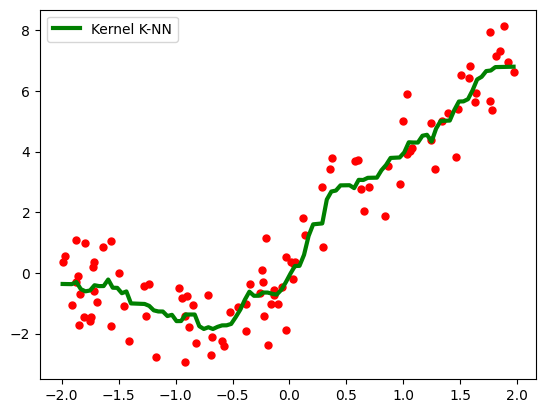

In [37]:
plt.plot(x, y, 'ro', ms=5)

datapoints = np.linspace(x.min(), x.max(), 100)
plt.plot(datapoints, univariate_kernelh_knn(x, y, bandwidth=best_model['bandwidth'], neighbors=int(best_model['neighbors']))(datapoints), 'g-', lw=3, label='Kernel K-NN')
plt.legend(loc='best')
plt.show()

3. In the following four scenarios, will the estimator be oversmoothed, undersmoothed, or perform relatively well? Give your reasons.
  - Using the optimal h and a very small k.
    - A small k results in a low number of neighbors, so it will be undersmoothed as the estimator will jump around everywhere. It can only be influenced by a small number of neighbors. When the covariates differ slightly, the neighbors that have an influence might be very different. Thus creating a rapidly changing estimate.
  - Using the optimal h and a very large k.
    - large k results in a high number of neighbors, so it will be oversmoothed as the estimator will stay around the average. Even if the covariates change, the neighbors stay mostly the same. Thus creating a very slow changing estimate.
  - Using the optimal k and a very small h.
    - small h results in stricter kernels. Stricter kernels create a lower influence on far away points. It results in a similar situation as a small k, so it will be undersmoothed. 
  - Using the optimal k and a very large h.
    - large h results in loose kernels. Looser kernels create more uniformly distributed weights. That means that it would be equal to a uniform kernel. As that kernel produces okay results, it essentially makes us drop one hyperparameter. With the only hyperparameter being optimal, the estimator will perform relatively well.

I assume that the optimal values are chosenby jointly optimizing the values. So, not by choosing a high/low value of one parameter and then optimizing the other parameter.

If the high/low parameter is set first and the other parameter is optimized afterwards, then my answer to optimal h and large k changes to performing relatively well. This is because the h is changed to be a stricter kernel. It essentially down-weights all the far away datapoints, effectively decreasing the (influence of a) number of neighbors.